In [1]:
__nbid__ = '0070'
__author__ = 'Isabella Olin <iolin@arizona.edu>, Stephanie Juneau <stephanie.juneau@noirlab.edu>'
__version__ = '20250109' # yyyymmdd
__datasets__ = ['sdss_dr17','sdss_dr16']
__keywords__ = ['extragalactic', 'galaxies','quenching','spectra','spectra stacking']

# SDSS/BOSS Large Scale Structure and Cosmic Slime Catalog
by Isabella Olin (University of Arizona), Stéphanie Juneau (NSF NOIRLab) & the Astro Data Lab Team

### Table of contents
* [Goals & Summary](#goals)
* [Disclaimer & attribution](#attribution)
* [Imports & setup](#import)
* [Query SDSS catalog](#query1)
* [Query Cosmic Slime Catalog](#query2)
* [Plot Query Results](#plots)
* [Coma Cluster](#coma)
* [Coma Cluster Spectra](#spectra)
* [References](#references)

<a class="anchor" id="goals"></a>
# Goals
* Compare sky coverage and redshift distributions of the SDSS SpecObj Catalog and the Cosmic Slime Value-Added Catalog (VAC)
* Plot the on-sky position of objects in and around the Coma Cluster, color-coded by matter density from the Cosmic Slime VAC
* Compare the matter density of the Coma Cluster to the field at the same redshift
* Create contours of matter density in the Coma Cluster
* Investigate SDSS spectra to look for signs of environment-dependent quenching. 

# Summary

From observing galaxies early in the Universe and those closer to home, we notice a trend. Over time, galaxies stop forming stars; they are becoming more quenched. What we’re still figuring out is why. What are the astrophysical mechanisms causing this trend of passive galaxies? In this Notebook, we explore matter density in the Coma Cluster using the Cosmic Slime Value Added Catalog to investigate the relationship between environment and galaxy quenching. We start by comparing the sky coverage between SDSS and Cosmic Slime and their redshift distributions. Here we note that the Cosmic Slime data is sparse past z = 0.1 and choose to focus on this lower redshift range. We then select a region centered around the Coma Cluster as an ideal location to probe a broad range of environments reaching high densities. By creating contours of matter density, we can visualize the distribution of matter in the cluster. We then examine SDSS spectra of galaxies, sorted by their local matter density, to search for signs of environment-dependent quenching. 

The Monte Carlo Physarum Machine (MCPM) was developed to model the optimized networking of Physarum polycephalum, the slime mold. When applied to galaxies, the MCPM traces out a matter density field revealing the filamentary structure of the Universe. This matter density field was probed at the location of SDSS galaxies to create the Cosmic Slime Value-Added Catalog ([Elek et. al 2020](https://direct.mit.edu/artl/article/28/1/22/108680/Monte-Carlo-Physarum-Machine-Characteristics-of), [Wilde et al. 2023](https://ui.adsabs.harvard.edu/abs/2023arXiv230102719W/abstract))

<a class="anchor" id="attribution"></a>
# Disclaimer & attribution

Disclaimers
-----------
Note that using the Astro Data Lab constitutes your agreement with our minimal [Disclaimers](https://datalab.noirlab.edu/disclaimers.php).

Acknowledgments
---------------
If you use **Astro Data Lab** in your published research, please include the text in your paper's Acknowledgments section:

_This research uses services or data provided by the Astro Data Lab, which is part of the Community Science and Data Center (CSDC) Program of NSF NOIRLab. NOIRLab is operated by the Association of Universities for Research in Astronomy (AURA), Inc. under a cooperative agreement with the U.S. National Science Foundation._

If you use **SPARCL jointly with the Astro Data Lab platform** (via JupyterLab, command-line, or web interface) in your published research, please include this text below in your paper's Acknowledgments section:

_This research uses services or data provided by the SPectra Analysis and Retrievable Catalog Lab (SPARCL) and the Astro Data Lab, which are both part of the Community Science and Data Center (CSDC) Program of NSF NOIRLab. NOIRLab is operated by the Association of Universities for Research in Astronomy (AURA), Inc. under a cooperative agreement with the U.S. National Science Foundation._

In either case **please cite the following papers**:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, https://doi.org/10.1117/12.2057445

* Astro Data Lab overview: Nikutta et al., "Data Lab - A Community Science Platform", Astronomy and Computing, 33, 2020, https://doi.org/10.1016/j.ascom.2020.100411

If you are referring to the Data Lab JupyterLab / Jupyter Notebooks, cite:

* Juneau et al., "Jupyter-Enabled Astrophysical Analysis Using Data-Proximate Computing Platforms", CiSE, 23, 15, 2021, https://doi.org/10.1109/MCSE.2021.3057097

If publishing in a AAS journal, also add the keyword: `\facility{Astro Data Lab}`

And if you are using SPARCL, please also add `\software{SPARCL}` and cite:

* Juneau et al., "SPARCL: SPectra Analysis and Retrievable Catalog Lab", Conference Proceedings for ADASS XXXIII, 2024
https://doi.org/10.48550/arXiv.2401.05576

The NOIRLab Library maintains [lists of proper acknowledgments](https://noirlab.edu/science/about/scientific-acknowledgments) to use when publishing papers using the Lab's facilities, data, or services.

<a class="anchor" id="import"></a>
# Imports and setup

In [2]:
# 3rd party
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from astropy.convolution import convolve, Gaussian2DKernel
import pandas as pd

# SPARCL imports
from sparcl.client import SparclClient

# Data Lab
from dl import queryClient as qc

In [3]:
## Setting up plots

# Font size
font = {'size':15}
matplotlib.rc('font', **font)

# Axes width
width = {'linewidth':2.0}
matplotlib.rc('axes', **width)

# x- and y- ticks
ticks = {'major.size':8.0, 'minor.size':4.0, 'major.width':2.0, 'minor.width':1.5, 'direction':'in',\
        'minor.visible':True}
matplotlib.rc('xtick', **ticks)
matplotlib.rc('ytick', **ticks)

# Include top and right ticks 
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

<a class="anchor" id="query1"></a>
# Query SDSS DR17

The SDSS DR17 database is called **sdss_dr17** and also includes several tables. We will use the **specobj** table, which has spectroscopic information.

In [4]:
# SDSS DR17 specobj; we will search up to redshift z<0.5115 to compare with the 
# Cosmic Slime catalog and only consider galaxies (class='GALAXY') 

# Write query statement (sql)
query = ("""
  SELECT z, ra, dec, specobjid 
  FROM sdss_dr17.specobj
  WHERE (z>0.0002 and z<0.5115 and class='GALAXY')
  """)

# z                 = redshift (z) from SDSS specObj table
# ra, dec           = RA, Dec of SDSS fiber from specObj table
# class             = Source class (Star, Galaxy, QSO) from SDSS
# specobjid         = Unique database ID based on PLATE, MJD, FIBERID, RUN2D

print(query)


  SELECT z, ra, dec, specobjid 
  FROM sdss_dr17.specobj
  WHERE (z>0.0002 and z<0.5115 and class='GALAXY')
  


In [5]:
# Call query client and return an Astropy Table
result = qc.query(sql=query, fmt='table')

In [6]:
# Print length of table (Nb of rows) and the first 10 rows
print(len(result))
result[:10]

1728836


z,ra,dec,specobjid
float64,float64,float64,int64
0.12142085,328.94453,44.1721,2889138948246890496
0.14196011,329.84453,44.2721,2889117232892241920
0.20890056,329.54453,44.9721,2889111735334103040
0.019433081,331.34453,44.9721,2889065555845736448
0.5036601,330.44453,45.5721,2889201345531766784
0.31619522,330.34453,46.2721,2877959108428851200
0.35590228,353.85034,45.049945,2124639424129034240
0.025425429,354.90534,45.082045,2124597367809271808
0.060469825,355.38141,45.568003,2124601490977875968


<a class="anchor" id="query2"></a>
# Query Cosmic Slime Catalog

The Cosmic Slime Value Added catalog was released with SDSS DR17 and can be found [here](https://www.sdss4.org/dr17/data_access/value-added-catalogs/?vac_id=cosmic-web-environmental-densities-from-mcpm-slimemold), with the data model (list of columns) described at https://data.sdss.org/datamodel/files/EBOSS_LSS/mcpm/MCPM_VER/slimeMold_galaxy_catalog.html

The Data model at Data Lab, as used in this Notebook, can be found at: https://datalab.noirlab.edu/query.php?name=sdss_dr17.eboss_mcpm


To learn more about the Cosmic Slime Value Added Catalog and how Wilde et. al optimized the MCPM, consult [Wilde et al. 2023](https://ui.adsabs.harvard.edu/abs/2023arXiv230102719W/abstract).

In [7]:
# sdss_dr17.eboss_mcpm is the Cosmic Slime Value Added Catalog
# To retrieve SPARCL SDSS DR16 spectra later in the notebook, we will join with 
# sdss_dr16.specobjall to obtain the DR16 specobjid's

#Write query statement (sql)
query = ("""
    SELECT C.ra, C.dec, C.z, C.matterdens, C.mcpm_run, S.specobjid 
    FROM sdss_dr17.eboss_mcpm as C
    JOIN sdss_dr16.specobjall as S on C.sdss_joinid = S.sdss_joinid
    """)

# ra, dec        = RA, Dec of SDSS fiber (J2000)
# z              = best redshift
# matterdens     = log10 of the ratio of the matter density relative to the mean matter density
# mcpm_run       = index of galaxy sample fitted simultaneously with MCPM
# specobjid      = DR16 specobjid to retrieve spectra from SPARCL by "specid"
# sdss_joinid    = SDSS identifier based on plate, mjd, fiberid that is constant across DR's

print(query)


    SELECT C.ra, C.dec, C.z, C.matterdens, C.mcpm_run, S.specobjid 
    FROM sdss_dr17.eboss_mcpm as C
    JOIN sdss_dr16.specobjall as S on C.sdss_joinid = S.sdss_joinid
    


In [8]:
#Call query client and return an Astropy Table
evt_data = qc.query(sql=query, fmt='table')

In [9]:
# Print length of table (Nb of rows) and the first 10 rows
print(len(evt_data))
evt_data[:10]

638820


ra,dec,z,matterdens,mcpm_run,specobjid
float64,float64,float64,float64,int64,int64
149.4869068955487,59.00149288161988,0.3781941,0.22516784,5,-9220861727639056384
149.4869068955487,59.00149288161988,0.3781941,0.551839,7,-9220861727639056384
146.714215072841,-1.041280023331374,0.021222278,1.7854924,0,299489677444933632
146.6285851269414,-0.7651620976591762,0.06465632,1.0360718,0,299490502078654464
146.6317064432559,-0.9883467023053,0.05265425,0.20140773,0,299491051834468352
146.9634997327016,-0.5447758299302171,0.055980586,0.8528137,0,299492701101910016
146.9635237026241,-0.7593404235056136,0.09708638,0.5238572,0,299492975979816960
146.5927838471015,-0.7602574022145185,0.064959235,1.2447993,0,299494075491444736
146.7283806728784,-0.5569743913807053,0.089311965,1.0173166,0,299494625247258624


<a class="anchor" id="plots"></a>
# Plot Query Results

## Sky Coverage: SDSS vs. Cosmic Slime

*The Slime Catalog uses SDSS surveys (subsets) and does not display the full range of SDSS data, so we expect only a partial overlap on the sky. The Slime Catalog has fewer objects than SDSS DR17.*

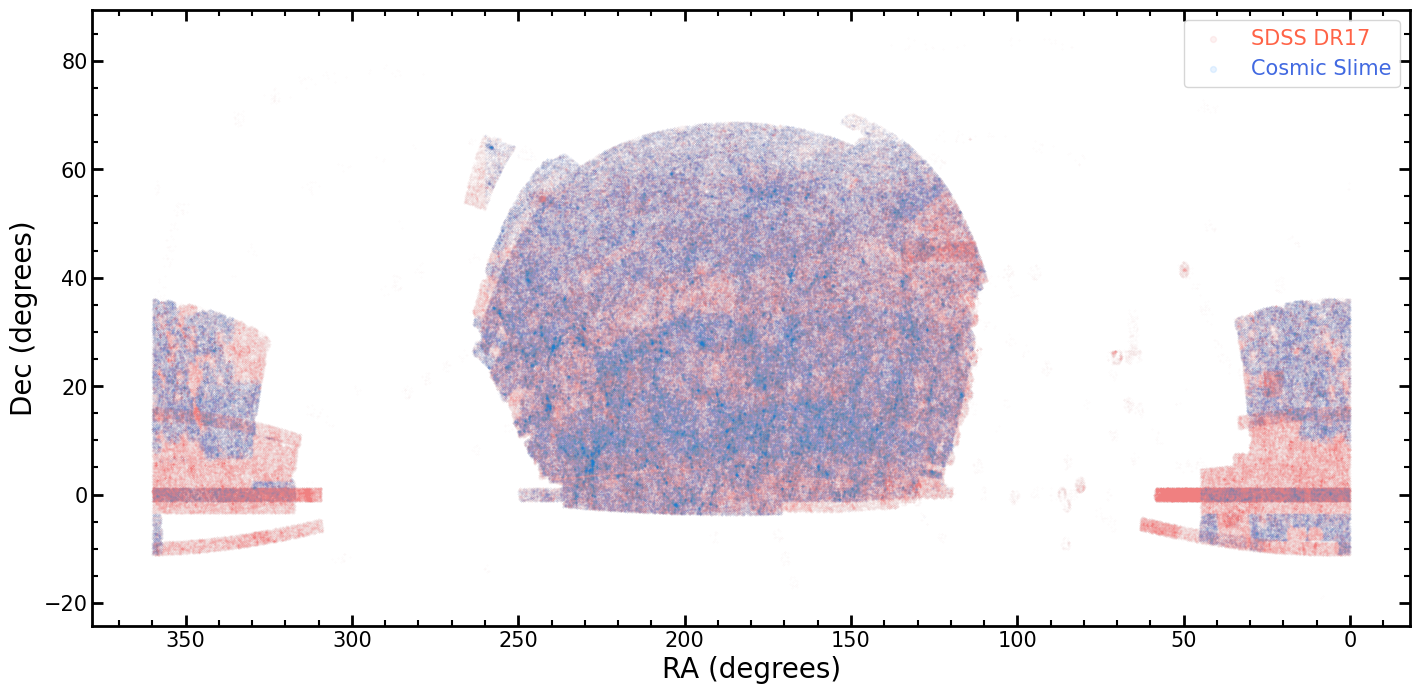

In [10]:
# Initialize the figure for sky coverage
fig, ax = plt.subplots(1,1,figsize=(17,8))

# Plot small dots for objects from SDSS and Cosmic Slime catalogs
ax.scatter(result['ra'],result['dec'],s=0.02,color='lightcoral',marker='o',alpha=0.1, label='SDSS DR17')
ax.scatter(evt_data['ra'],evt_data['dec'],s=0.02,color='dodgerblue',marker='o',alpha=0.1, label='Cosmic Slime')

# Reverse order of horizontal axis so that RA increases to the left (East)
ax.set_xlim(reversed(ax.set_xlim()))

# Label axes and legend
ax.set_xlabel("RA (degrees)", fontsize=20)
ax.set_ylabel("Dec (degrees)", fontsize=20)
# Using slightly darker colors for the legend labels for better legibility
plt.legend(loc='upper right',markerscale=30, labelcolor=['tomato','royalblue'])

## User: Uncomment the following line to locate the Coma Cluster, which we will be investigating later
#ax.add_patch(Rectangle((190, 25),10,7,fill=False,color='white'))
# ^ note: even here you can see the Coma Cluster
plt.show()

## Cosmic Slime Galaxy Redshift Distribution

The Cosmic Slime Catalog has a column labeled 'mcpmRun', indicating which model run the object is part of. Here we plot a distribution of sources' redshifts sorted by mcpmRun. Run0 are samples from the NASA Sloan Atlas and the higher redshift runs (Run1 - Run8) are Luminous Red Galaxies (LRGs) sampled from BOSS.

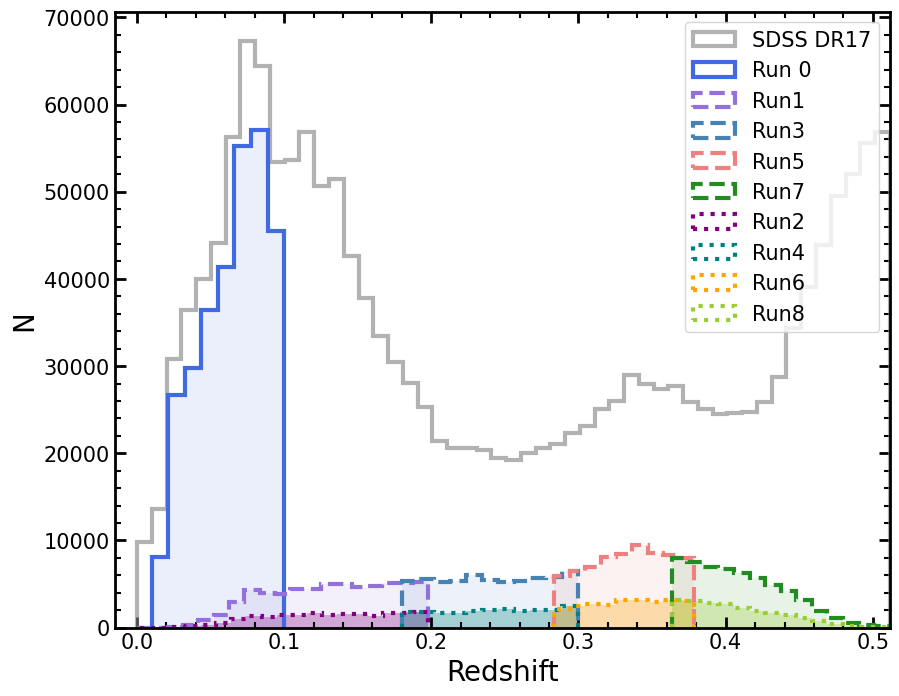

In [11]:
# maintain constant bin size
bsize = 0.01
runs = [0,1,3,5,7,2,4,6,8]
colors = ['royalblue','mediumpurple','steelblue','lightcoral','forestgreen','purple','teal','orange','yellowgreen']

nbins_sdss = int((np.max(result['z']) - np.min(result['z']))/bsize)

fig, (ax) = plt.subplots(1, 1, figsize=(10, 8))

# plot SDSS DR16 redshift distribution
ax.hist(result['z'],bins=nbins_sdss,histtype='step',color='gray',label='SDSS DR17',linewidth=3, alpha=0.6)

# loop over mcpm runs
for i,run_i in enumerate(runs):
    zbin = evt_data['z'][evt_data['mcpm_run'] == run_i]
    zmin = np.min(zbin)
    zmax = np.max(zbin)
    Nbins = int((zmax-zmin)/bsize)
    
    # plot redshift distribution for Run 0 (NSA/SDSS)
    if run_i == 0:
        ax.hist(zbin,bins=Nbins,histtype='stepfilled',color=colors[i],alpha=0.1)
        ax.hist(zbin,bins=Nbins,histtype='step',color=colors[i],label='Run 0',linewidth=3)
   
    # plot redshift distribution for Runs 1, 3, 5, & 7 (LRG-NGC)
    elif run_i%2 != 0:
        ax.hist(zbin,bins=Nbins,color=colors[i],histtype='stepfilled',alpha=0.1)
        ax.hist(zbin,bins=Nbins,color=colors[i],histtype='step',linestyle='dashed',label='Run' + str(run_i),linewidth=3)
   
    # plot redshift distributions for Runs 2, 4, 6, 8 (LRG-SGC)
    else:
        ax.hist(zbin,bins=Nbins,color=colors[i],histtype='stepfilled',alpha=0.3)
        ax.hist(zbin,bins=Nbins,color=colors[i],histtype='step',linestyle='dotted',label='Run' + str(run_i),linewidth=3)

ax.set_xlim(-0.015,0.5115)
ax.set_xlabel('Redshift',fontsize=20)
ax.set_ylabel('N',fontsize=20)
plt.legend(loc='upper right')

We note the overlaps between MCPM runs to prevent discontinuities in the catalog. For this Notebook, we will be focusing on a low redshift structure in Run0, the Coma Cluster

In [12]:
# Keep only Run0 (mcpm_run = 0)
evt_data = evt_data[evt_data['mcpm_run'] == 0]

<a class="anchor" id="coma"></a>
# Coma Cluster

The Coma Cluster is one of the most well-studied massive galaxy clusters in the observable universe. With over 1,000 identified galaxies, it is very rich and will provide a good range of high and low density regions. This makes the Coma Cluster a good target for investigating the relationship between environment and galaxy quenching. 

## Locating the Coma Cluster
For this notebook, we will consider targets in the Coma Cluster to be within the redshift range 0.0142 ≤ z ≤ 0.0328 ([Tiwari et al. 2020](https://ui.adsabs.harvard.edu/abs/2020NewA...8101417T/abstract); also [Rines et al. 2005](https://iopscience.iop.org/article/10.1086/433173))

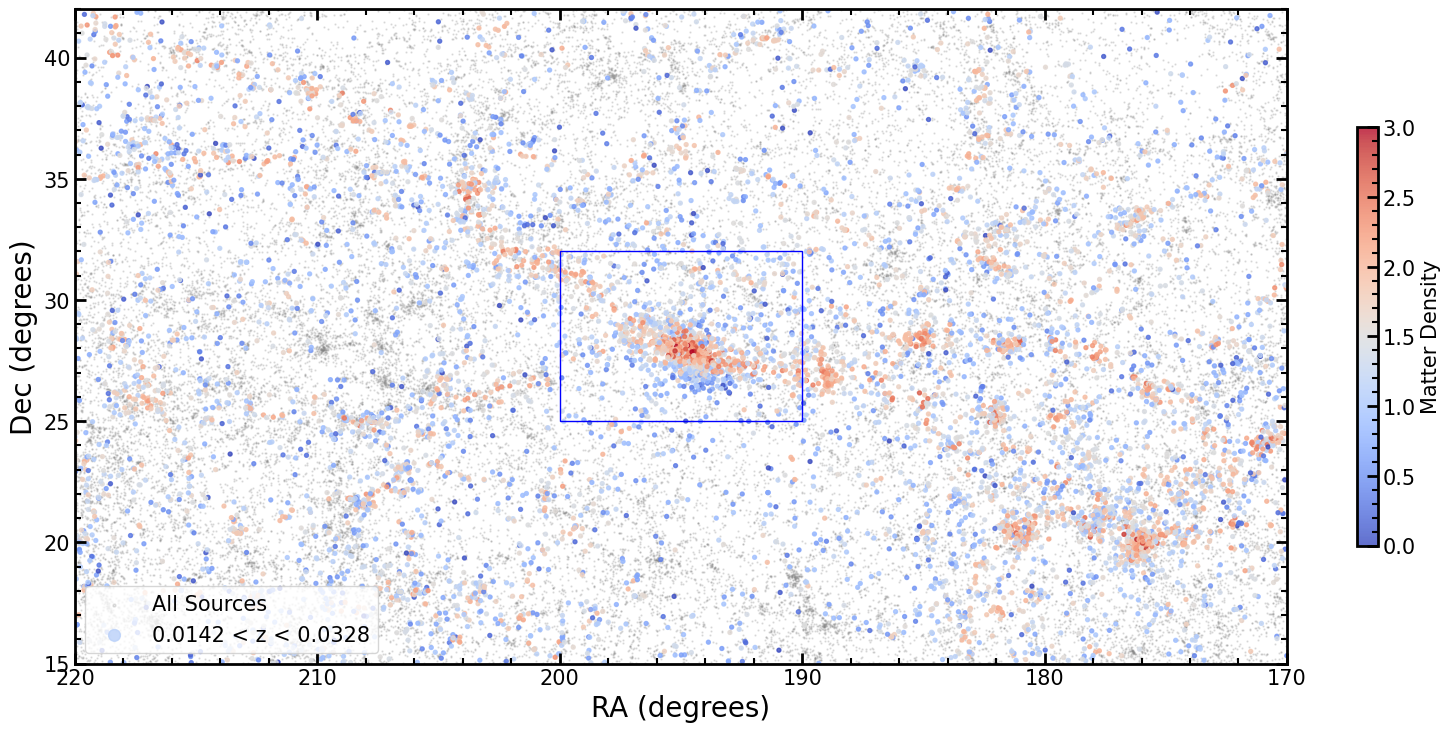

In [13]:
# Select redshift slice corresponding to the Coma Cluster
coma_z = (evt_data['z'] > 0.0142) & (evt_data['z'] < 0.0328)

# Mask location of the Coma Cluster
coma_ra = (evt_data['ra'] > 190) & (evt_data['ra'] < 200)
coma_dec = (evt_data['dec'] > 25) & (evt_data['dec'] < 32)
coma_ra_large = (evt_data['ra'] > 170) & (evt_data['ra'] < 220)
coma_dec_large = (evt_data['dec'] > 15) & (evt_data['dec'] < 42)

# initialize the figure
fig, (ax1) = plt.subplots(1, 1, figsize=(18, 8.5))

# plot all points in gray (all redshifts)
ax1.scatter(evt_data['ra'][coma_ra_large&coma_dec_large],evt_data['dec'][coma_ra_large&coma_dec_large],s=0.5,color='gray',marker='o',alpha=0.2,label='All Sources')

# overplot objects from redshift slice by their matter density
im = ax1.scatter(evt_data['ra'][coma_ra_large&coma_dec_large&coma_z],evt_data['dec'][coma_ra_large&coma_dec_large&coma_z],s=8,c=evt_data['matterdens'][coma_ra_large&coma_dec_large&coma_z],
                 norm = 'linear',vmin=0,vmax=3,marker='o',alpha=0.8,cmap='coolwarm',label = '0.0142 < z < 0.0328')

# Extent of RA, Dec (in degrees) to plot
xmin = 170.
xmax = 220.
ymin = 15.
ymax = 42.

ax1.axis([xmin, xmax, ymin, ymax])
ax1.set_xlim(reversed(ax1.set_xlim())) # flip the x-axis
ax1.set_xlabel("RA (degrees)", fontsize=20)
ax1.set_ylabel("Dec (degrees)", fontsize=20)
ax1.set_aspect('equal')

# add rectangle to show where we zoom in next cell
ax1.add_patch(Rectangle((190, 25),10,7,fill=False,color='b'))
ax1.legend(loc = 'lower left', markerscale=3)

cb = fig.colorbar(im,label='Matter Density',fraction = 0.015, orientation='vertical')
plt.show()

The panel above shows objects from the Cosmic Slime Catalog in a broader region around the Coma Cluster. Here we display targets across all redshifts in gray and targets in the Coma Cluster redshift range color mapped by matter density. We can easily spot the Coma Galaxy Cluster, as well as some potential smaller clusters and filamentary structures. The blue rectangle shows a selected region we zoom in to the next cell. 

## A closer look

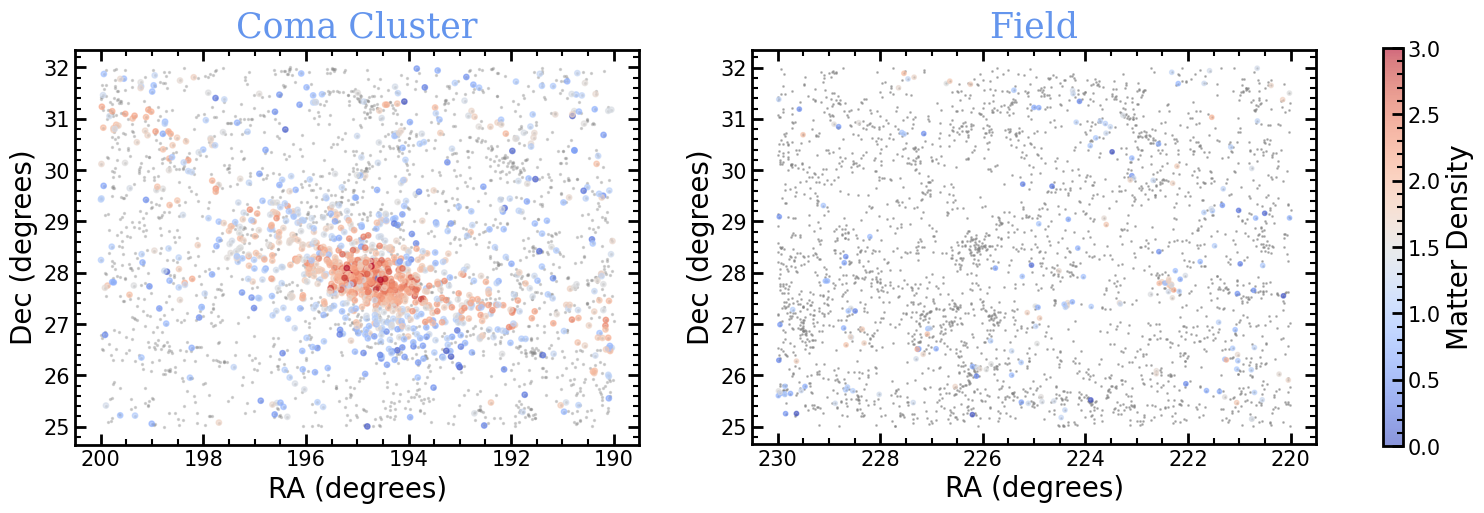

In [14]:
# Mask area to compare Coma Cluster to a control Field region (same angular size & dec)
control_ra = (evt_data['ra'] > 220) & (evt_data['ra'] < 230)
control_dec = (evt_data['dec'] > 25) & (evt_data['dec'] < 32)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,6.5))
plt.subplots_adjust(right=1.01)

# plot all points in gray (all redshifts, Coma Cluster Ra & Dec) 
ax1.scatter(evt_data['ra'][coma_ra&coma_dec],evt_data['dec'][coma_ra&coma_dec],s=2,color='gray',marker='o',alpha=0.3)

# overplot objects from redshift slice by their matter density (Coma Cluster Ra & Dec)
im1 = ax1.scatter(evt_data['ra'][coma_ra&coma_dec&coma_z],evt_data['dec'][coma_ra&coma_dec&coma_z],s=15,c=evt_data['matterdens'][coma_ra&coma_dec&coma_z],cmap = 'coolwarm', 
                  norm = 'linear',vmin=0,vmax=3,marker='o',alpha=0.6)
ax1.set_xlim(reversed(ax1.set_xlim()))
ax1.set_xlabel("RA (degrees)", fontsize=20)
ax1.set_ylabel("Dec (degrees)", fontsize=20)
ax1.text(195,32.8,'Coma Cluster',ha='center',va = 'center',fontsize=25,color='cornflowerblue',family='serif')
ax1.set_aspect('equal')

# plot all points in gray (all redshifts, control Field region)
ax2.scatter(evt_data['ra'][control_ra&control_dec],evt_data['dec'][control_ra&control_dec],s=1,color='gray',marker='o',alpha=0.5)

# overplot objects from redshift slice by their matter density (Field)
im2 = ax2.scatter(evt_data['ra'][control_ra&control_dec&coma_z],evt_data['dec'][control_ra&control_dec&coma_z],s=10,c=evt_data['matterdens'][control_ra&control_dec&coma_z],cmap = 'coolwarm',
                  norm = 'linear',vmin=0,vmax=3,marker='o',alpha=0.6)

ax2.set_xlim(reversed(ax2.set_xlim()))
ax2.set_xlabel("RA (degrees)", fontsize=20)
ax2.set_ylabel("Dec (degrees)", fontsize=20)
ax2.text(225,32.8,'Field',ha='center',va = 'center',fontsize=25,color='cornflowerblue',family='serif')
ax2.set_aspect('equal')

# Color bar
cb = fig.colorbar(im2,ax=(ax1,ax2),fraction = 0.015, orientation='vertical').set_label(label="Matter Density",size=20);

The two figures above show smaller regions of sky, zooming in to the Coma Cluster and a field region at the same Declination and redshift. As expected, the Coma Cluster's matter density is highest at its center. We can further explore the distribution of matter density in the Coma Cluster by visualizing contour lines. 

## Matter Density Contours

In [15]:
# mask area for contours 
coma_ra_small = (evt_data['ra'] > 194.4) & (evt_data['ra'] < 195.6)
coma_dec_small = (evt_data['dec'] > 27.4) & (evt_data['dec'] < 28.5)

# initialize gaussian kernel
gauss_kernel = Gaussian2DKernel(2)

# create unweighted 2D histogram of Coma Cluster ra & decs
dens_1, _, _ = np.histogram2d((evt_data['ra'][coma_ra_small&coma_dec_small&coma_z]), (evt_data['dec'][coma_ra_small&coma_dec_small&coma_z]),range=[[194.4,195.6],[27.4,28.5]], bins=35)
dens_1 = convolve(dens_1, gauss_kernel)
dens_1 = dens_1.T

# create 2D histogram of Coma Cluster ra & decs weighted by matter density
dens_2, _, _ = np.histogram2d((evt_data['ra'][coma_ra_small&coma_dec_small&coma_z]), (evt_data['dec'][coma_ra_small&coma_dec_small&coma_z]),range=[[194.4,195.6],[27.4,28.5]], bins=35, 
                            weights=10**(evt_data['matterdens'][coma_ra_small&coma_dec_small&coma_z]))
dens_2 = convolve(dens_2, gauss_kernel)
dens_2 = dens_2.T

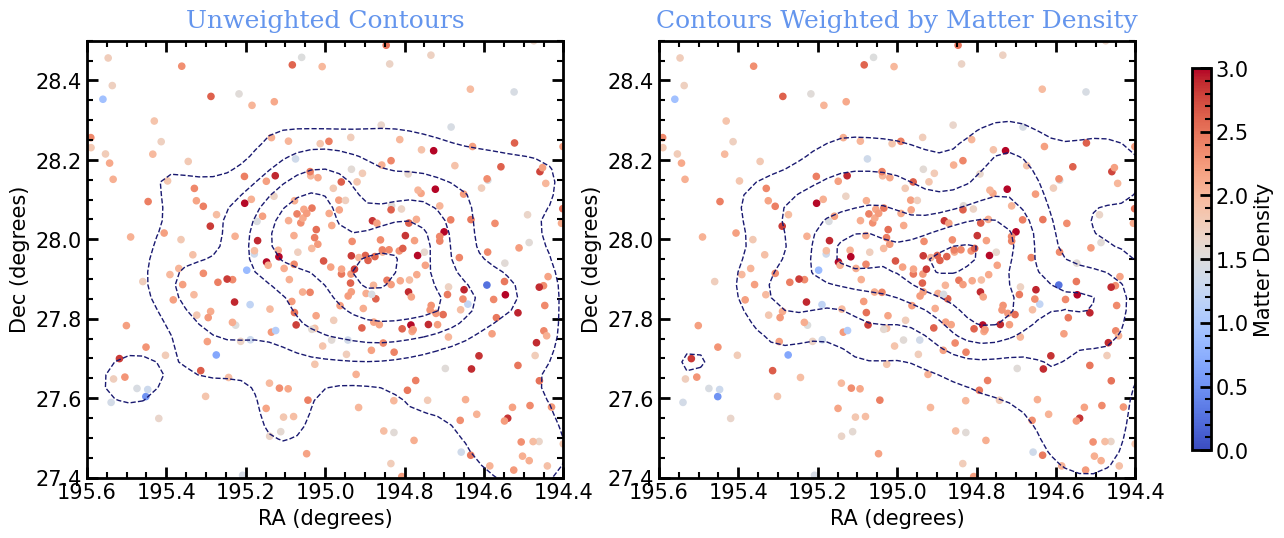

In [16]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14.5,6.5))
                          
# plot objects in coma cluster by their matter density
im1 = ax1.scatter(evt_data['ra'][coma_ra_small&coma_dec_small&coma_z],evt_data['dec'][coma_ra_small&coma_dec_small&coma_z],c=evt_data['matterdens'][coma_ra_small&coma_dec_small&coma_z],
                  cmap = 'coolwarm', norm = 'linear', vmin=0,vmax=3, marker='o',s=20,alpha=1)

# overplot unweighted contours
cntra1 = ax1.contour(dens_1, colors = 'midnightblue',linestyles='dashed', linewidths=1, extent=(194.4,195.6,27.4,28.5),levels=[0.2,0.34,0.48,0.62,0.76])

ax1.set_xlim(reversed(ax1.set_xlim()))
ax1.set_xlabel("RA (degrees)", fontsize=15)
ax1.set_ylabel("Dec (degrees)", fontsize=15)
ax1.text(195,28.55,'Unweighted Contours',ha='center',va = 'center',fontsize=18,color='cornflowerblue',family='serif')
ax1.set_aspect('equal')

# plot objects in coma cluster by their matter density
im2 = ax2.scatter(evt_data['ra'][coma_ra_small&coma_dec_small&coma_z],evt_data['dec'][coma_ra_small&coma_dec_small&coma_z],c=evt_data['matterdens'][coma_ra_small&coma_dec_small&coma_z],
                  cmap = 'coolwarm', norm = 'linear',vmin=0,vmax=3,marker='o',s=20,alpha=1)

# overplot contours weighted by matter density
cntra2 = ax2.contour(dens_2, colors = 'midnightblue',linestyles='dashed', linewidths=1, extent=(194.4,195.6,27.4,28.5),levels=[40,85,130,175,220])

ax2.set_xlim(reversed(ax2.set_xlim()))
ax2.set_xlabel("RA (degrees)", fontsize=15)
ax2.set_ylabel("Dec (degrees)", fontsize=15)
ax2.text(195,28.55,'Contours Weighted by Matter Density',ha='center',va = 'center',fontsize=18,color='cornflowerblue',family='serif')
ax2.set_aspect('equal')

cb = plt.colorbar(im1,ax = (ax1,ax2),label='Matter Density',fraction=0.017)

Both panels plot targets in the Coma Cluster color mapped by their matter density. The left panels show contours that don't consider matter density, only the number density of objects. The graph on the right shows contours weighted by their matter density, on a linear scale. Because these weights do not produce the same contours, we know there is extra information beyond number density. *Matter* density estimates may provide a more accurate picture of a cluster's structure.


<a class="anchor" id="spectra"></a>
# Coma Cluster Spectra

Next, we will retrieve SDSS spectra with [SPARCL](https://astrosparcl.datalab.noirlab.edu/). These figures show the stacked spectra of our bins: Each spectrum is the average of the combined light from all the stars in galaxies grouped by similar environments (surrounding matter density). By examining spectral tracers of star formation and stellar population ages, we examine the average spectra for a given environment to find galaxy quenching trends.

In [17]:
# Instantiate the SPARCL client to retrieve spectra below
client = SparclClient()

### Functions to access and stack SDSS spectra

add_lines() and stack_specta() are adapted from notebooks-latest/03_ScienceExamples/EmLineGalaxies/01_EmLineGalaxies_SpectraStack.ipynb

In [18]:
def add_lines(z, ax = None, rest_frame = True, em_label = True, abs_label = True, em_lines = None, abs_lines = None):
    """
    Function to add emission and/or absorption lines onto a plot. 
    
    If em_lines or abs_lines is given, plotting only the specified lines.
    If no lines are given, plotting all the lines that are present in x-range of the plot.
    
    Parameters
    ----------
    z : float
        Redshift value of the source
    
    ax : AxesSubplot
        The axis onto which the emission/absoption lines needs to be plotted.
        If ax = None, then the plotting function uses plt, rather than axis.
        
    rest_frame : bool
        Whether or not the plot is in rest-frame. Default is True.
    
    em_label : bool
        Whether or not to label the emission lines. Default is True.
        
    abs_label : bool
        Whether or not to label the absorption lines. Default is True.
    
    em_lines : list
        List of emission lines to label
    
    abs_lines : list
        List of absorption lines to label
    
    Returns
    -------
    None
    
    """
    
    # List of lines
    # This is the set of emission lines from the spZline files. 
    # All the wavelengths are in vaccuum wavelengths.

    # Emission Lines
    emission_lines = [
    {"name" : "Ly-alpha",       "lambda" : 1215.67,  "emission": True,  "label" : "Ly$\\alpha$"},
    {"name" : "N V 1240",       "lambda" : 1240.81,  "emission": True,  "label" : "N V"},
    {"name" : "C IV 1549",      "lambda" : 1549.48,  "emission": True,  "label" : "C IV" },
    {"name" : "He II 1640",     "lambda" : 1640.42,  "emission": True,  "label" : "He II"},
    {"name" : "C III] 1908",    "lambda" : 1908.734, "emission": True,  "label" : "C III]"},
    {"name" : "Mg II 2799",     "lambda" : 2800.315, "emission": True,  "label" : "Mg II" },
    {"name" : "[O II] 3725",    "lambda" : 3727.092, "emission": True,  "label" : " "},
    {"name" : "[O II] 3727",    "lambda" : 3729.875, "emission": True,  "label" : "[O II]"}, 
    {"name" : "[Ne III] 3868",  "lambda" : 3869.857, "emission": True,  "label" : "[Ne III]"},
    {"name" : "H-zeta",         "lambda" : 3890.151, "emission": True,  "label" : "H$\\zeta$"},
    {"name" : "[Ne III] 3970",  "lambda" : 3971.123, "emission": True,  "label" : "[Ne III]"},
    {"name" : "H-epsilon",      "lambda" : 3971.195, "emission": True,  "label" : "H$\\epsilon$"}, 
    {"name" : "H-delta",        "lambda" : 4102.892, "emission": True,  "label" : "H$\\delta$"},
    {"name" : "H-gamma",        "lambda" : 4341.684, "emission": True,  "label" : "H$\\gamma$"},
    {"name" : "[O III] 4363",   "lambda" : 4364.435, "emission": True,  "label" : "[O III]"},
    {"name" : "He II 4685",     "lambda" : 4686.991, "emission": True,  "label" : "He II"},
    {"name" : "H-beta",         "lambda" : 4862.683, "emission": True,  "label" : "H$\\beta$"},
    {"name" : "[O III] 4959",   "lambda" : 4960.294, "emission": True,  "label" : "[O III]" },
    {"name" : "[O III] 5007",   "lambda" : 5008.239, "emission": True,  "label" : "[O III]" },
    {"name" : "He II 5411",     "lambda" : 5413.025, "emission": True,  "label" : "He II"},
    {"name" : "[O I] 5577",     "lambda" : 5578.888, "emission": True,  "label" : "[O I]" },
    {"name" : "[N II] 5755",    "lambda" : 5756.186, "emission": True,  "label" : "[Ne II]" },
    {"name" : "He I 5876",      "lambda" : 5877.308, "emission": True,  "label" : "He I" },
    {"name" : "[O I] 6300",     "lambda" : 6302.046, "emission": True,  "label" : "[O I]" },
    {"name" : "[S III] 6312",   "lambda" : 6313.806, "emission": True,  "label" : "[S III]" },
    {"name" : "[O I] 6363",     "lambda" : 6365.535, "emission": True,  "label" : "[O I]" },
    {"name" : "[N II] 6548",    "lambda" : 6549.859, "emission": True,  "label" : "[N II]" },
    {"name" : "H-alpha",        "lambda" : 6564.614, "emission": True,  "label" : "H$\\alpha$" },
    {"name" : "[N II] 6583",    "lambda" : 6585.268, "emission": True,  "label" : "[N II]" },
    {"name" : "[S II] 6716",    "lambda" : 6718.294, "emission": True,  "label" : "[S II]" },
    {"name" : "[S II] 6730",    "lambda" : 6732.678, "emission": True,  "label" : "[S II]" },
    {"name" : "[Ar III] 7135",  "lambda" : 7137.758, "emission": True,  "label" : "[Ar III]" },]


    # Absorption lines
    absorption_lines = [
    {"name" : "H12",            "lambda" : 3751.22,  "emission": False, "label" : "H12"},
    {"name" : "H11",            "lambda" : 3771.70,  "emission": False, "label" : "H11"},
    {"name" : "H10",            "lambda" : 3798.98,  "emission": False, "label" : "H10"},
    {"name" : "H9",             "lambda" : 3836.48,  "emission": False, "label" : "H9"},
    {"name" : "H-zeta",         "lambda" : 3890.151, "emission": False, "label" : "H$\\zeta$" },
    {"name" : "K (Ca II 3933)", "lambda" : 3934.814, "emission": False, "label" : "K (Ca II)"},
    {"name" : "H (Ca II 3968)", "lambda" : 3969.623, "emission": False, "label" : "H (Ca II)"},
    {"name" : "H-epsilon",      "lambda" : 3971.195, "emission": False, "label" : "H$\\epsilon$"}, 
    {"name" : "H-delta",        "lambda" : 4102.892, "emission": False, "label" : "H$\\delta$" },
    {"name" : "G (Ca I 4307)",  "lambda" : 4308.952, "emission": False, "label" : "G (Ca I)"},
    {"name" : "H-gamma",        "lambda" : 4341.684, "emission": False, "label" : "H$\\gamma$"},
    {"name" : "H-beta",         "lambda" : 4862.683, "emission": False, "label" : "H$\\beta$"},
    {"name" : "Mg I 5183",      "lambda" : 5185.048, "emission": False, "label" : " "},
    {"name" : "Mg I 5172",      "lambda" : 5174.125, "emission": False, "label" : " "},
    {"name" : "Mg I 5167",      "lambda" : 5168.762, "emission": False, "label" : "Mg I"},
    {"name" : "D2 (Na I 5889)", "lambda" : 5891.582, "emission": False, "label" : " " },
    {"name" : "D1 (Na I 5895)", "lambda" : 5897.554, "emission": False, "label" : "D1,2 (Na I)" },
    {"name" : "H-alpha",        "lambda" : 6564.614, "emission": False, "label" : "H$\\alpha$"},
    ]
    
    if (ax == None):
        # If there is no axes given, plotting with the plt function
        ax = plt.gca()
    
    if (em_lines != None):
        # Choosing the emission lines listed by the user
        emission_lines = list(filter(lambda x: x['name'] in em_lines, emission_lines))
    
    if (abs_lines != None):
        # Choosing the absorption lines listed by the user
        absorption_lines = list(filter(lambda x: x['name'] in abs_lines, absorption_lines)) 
    
    xbounds = ax.get_xbound()   # Getting the x-range of the plot 
    # This is for selecting only those lines that are visible in the x-range of the plot
    
    for ii in range(len(emission_lines)):
        # If rest_frame = False, redshifting the emission lines to the observed frame of the source
        if (rest_frame == False):
            lam = emission_lines[ii]['lambda']*(1+z)
        else:
            lam = emission_lines[ii]['lambda']
        # Plotting the emission lines if they are within the x-range of the plot
        if (emission_lines[ii]['emission']) & (lam > xbounds[0]) & (lam < xbounds[1]):
            ax.axvline(lam, 0.95, 1.0, color = 'b', lw = 1.0,alpha=0.7)
            ax.axvline(lam, color = 'b', lw = 1.0, linestyle = ':',alpha=0.7)
            trans = ax.get_xaxis_transform()
            if (em_label == True):
                # Labeling the emission lines if em_label = True
                ax.annotate(emission_lines[ii]['label'], xy = (lam, 1.05), xycoords = trans, \
                         fontsize = 12, rotation = 90, color = 'b')
            
    for ii in range(len(absorption_lines)):
        # If rest_frame = False, redshifting the absorption lines to the observed frame of the source
        if (rest_frame == False):
            lam = absorption_lines[ii]['lambda']*(1+z)
        else:
            lam = absorption_lines[ii]['lambda']
        # Plotting the absorption lines if they are within the x-range of the plot
        if (lam > xbounds[0]) & (lam < xbounds[1]):
            ax.axvline(lam, 0.2, 1.0, color = 'r', lw = 1.0, linestyle = ':',alpha=0.5)
            trans = ax.get_xaxis_transform()
            if (abs_label == True):
                # Labeling the absorption lines if abs_label = True
                ax.annotate(absorption_lines[ii]['label'], xy = (lam, 0.7), xycoords = trans, \
                         fontsize = 12, rotation = 90, color = 'r')

In [19]:
def stack_spectra(specobjids):
    """
    Function to stack the spectra of all the sources in the input list of IDs.
    Uses SPARCL to retrieve spectra
    
    Returns a mean of the input spectra (with a default normalization by the median continuum 
    at rest-frame 6800-7000AA).
    
    Parameters
    ----------
    specobjids : list of integers
        List of SDSS specObjIds for the spectra to be stacked
    
    Returns
    -------
    wavelength_stack : array
        Wavelength array of the stacked spectrum
        
    flux_stack : array
        Flux array of the stacked spectrum

    [not yet implemented] ivar_stack : array
        Inverse variance (IVAR) of the stacked spectrum
    """
    
    # Create an array with the targeted loglam values - reference array
    loglam_ref = np.arange(3.5000, 3.9000, 0.0001).astype('float32')
    
    # Create empty lists for flux and ivar 
    flux_array = []
    ivar_array = []
       
    # Number of spectra
    n = len(specobjids)

    ## Retrieve the spectra
    res = client.retrieve_by_specid(specid_list = specobjids, 
                                    include = ['sparcl_id', 'specid', 'redshift', 'flux', 'wavelength', 'ivar'],
                                    dataset_list = ['SDSS-DR16', 'BOSS-DR16'])
    
    ## All the spectra have the same spacing in log wavelength.
    ## We shift the spectra in the observed wavelength range to fill the same log wavelength range
    ## Join the different arrays of the individual spectra into a single array
    
    ## Compared the number of retrieved spectra to the number of requested spectra
    ## NOTE: some datasets have missing spectra with inconsistent data models, which will be added at the 
    ##       next re-ingestion. Stats available here: https://astrosparcl.datalab.noirlab.edu/sparc/datasetnotes/
    n_res = res.count
    n_use = np.min([n_res, n])
    if n_res!=n:
        print(f"WARNING: {n_res} spectra were retrieved from the requested {n}! Will proceed with {n_use} spectra.")
        
    for ii in range(n_use):   
                
        ## Get rest-frame spectra of each object
        res_rec = res.records[ii]
        z = res_rec.redshift
        lam = res_rec.wavelength/(1+z)
        flux = res_rec.flux*(1+z)
        ivar = res_rec.ivar/((1+z)**2)
        
        loglam = np.around(np.log10(lam), 4).astype('float32')
        # The log of reference wavelength and log of wavelength range of each spectra are converted to 'float32'
        # This helps in avoiding the rounding errors
        
        # Creating empty arrays for flux, inverse variance
        # with the same length as the reference loglam array
        fl = np.zeros(len(loglam_ref))
        iv = np.zeros(len(loglam_ref))
        
        # Truth_array - A boolen array which will define what pixels the spectra have been shifted to
        truth_array = np.zeros(len(loglam_ref), dtype = bool)
        
        # Find common elements between the reference and spectra wavelengths - 
        ll_common = np.intersect1d(loglam_ref, loglam)
        
        # Finding the indices of the first pixel in the common array in both reference and spectrum arrays
        ref_start = np.where(loglam_ref == ll_common[0])[0][0]
        spec_start = np.where(loglam == ll_common[0])[0][0]
        
        m = min(len(loglam_ref[ref_start:]), len(loglam[spec_start:]))
        
        # Match the first pixel of the common loglam values with the reference array 
        # Mark the number of pixels with the spectra starting from the first pixel to be True
        truth_array[ref_start:ref_start+m] = True

        # Fill the flux, inverse variance arrays
        fl[truth_array] = flux[spec_start:spec_start+m]
        iv[truth_array] = ivar[spec_start:spec_start+m]
        
        # Where the reference array is empty, fill the flux with nan values
        # Set inverse variance to zero for these pixels
        fl[~truth_array] = np.nan
        iv[~truth_array] = 0.0
        
        # Create a masked array with 'nan' values marked
        # This avoids the pixels filled with 'nan' when stacking
        fl = np.ma.masked_array(fl, np.isnan(fl))
        iv = np.ma.masked_array(iv, np.isnan(iv))

        # Normalization factor for individual spectra
        norm = np.ma.median(fl[(loglam_ref>np.log10(6800))&(loglam_ref<np.log10(7000))])

        flux_array.append(fl/norm)  #normalized
        ivar_array.append(iv)
        
    # Stack the spectra by averaging the (normalized) flux arrays
    wavelength_stack = 10**(loglam_ref)
    flux_stack = np.ma.average(flux_array, axis = 0)        
    flux_stack = flux_stack.filled(np.nan)
    
    return (wavelength_stack, flux_stack)

## Binning Coma Cluster targets by matter density

First, we create a histogram to choose the bins that we will use in investigating spectral trends as a function of matter density.

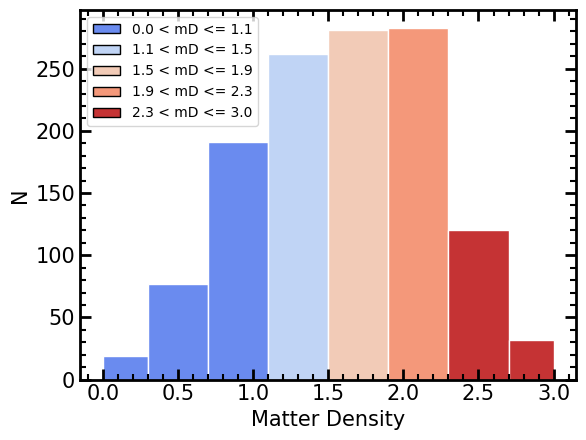

In [20]:
# colors, levels, and labels for plots
cmap = plt.get_cmap('coolwarm')
colors = [cmap(0.15),cmap(0.4),cmap(0.6),cmap(0.75),cmap(0.95)]
bin_levels = [0.0,1.1,1.5,1.9,2.3,3.0]
labels = ['0.0 < mD <= 1.1','1.1 < mD <= 1.5','1.5 < mD <= 1.9','1.9 < mD <= 2.3','2.3 < mD <= 3.0']
Nbins = len(colors)

# colors and bin levels for histogram
hist_colors = [cmap(0.15),cmap(0.15),cmap(0.15),cmap(0.4),cmap(0.6),cmap(0.75),cmap(0.95),cmap(0.95)]
hist_levels = [0,0.3,0.7,1.1,1.5,1.9,2.3,2.7,3.0]

# plot histogram of matter density in coma cluster
fig, ax = plt.subplots()
data = np.random.rand(1000)

N, bins, patches = ax.hist(evt_data['matterdens'][coma_ra&coma_dec&coma_z], edgecolor='white', linewidth=1,bins= hist_levels)

#color histogram bins by matter density bin levels
index = 0
for n in range(len(hist_levels)-1):
    for i in range(index,index+1):
        patches[i].set_facecolor(hist_colors[index])
        index += 1

ax.set_xlabel('Matter Density')
ax.set_ylabel('N')

handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in colors]
plt.legend(handles, labels,fontsize=10)
plt.show()

These matter density levels were chosen to create roughly equal-sized bins. Here and from now on, "mD" represents "matter density." 

Next, we create masks for each bin and apply these masks to our original data frame to obtain five new Coma Cluster data frames. 

In [21]:
# create masks for each matter density bin 
bin_masks = []
for i in range(Nbins):
    bin_mask = (evt_data['matterdens'] > bin_levels[i]) & (evt_data['matterdens'] <= bin_levels[i+1])
    bin_masks.append(bin_mask)

# select sources for each bin using masks
bins = []
for i in range(Nbins):
    coma_bin = evt_data[coma_ra&coma_dec&coma_z&bin_masks[i]].as_array()
    bins.append(coma_bin)
    print(f"Bin {i+1} contains N= {len(bins[i])}")

Bin 1 contains N= 287
Bin 2 contains N= 262
Bin 3 contains N= 281
Bin 4 contains N= 283
Bin 5 contains N= 152


Here, we stack the spectra of all the objects in each bin individually and append the stacked outputs (wavelength, flux, model) to a list. 

In [22]:
# initialize output lists
wavelength_stacks = []
flux_stacks = []
model_stacks = []
med_matterdens = []

# for each bin, obtain the stacked wavelength, flux, and modeled flux
for bin_name in (bins):
    specobjids_bin = bin_name['specobjid'].tolist()
    wavelength_out,flux_out = stack_spectra(specobjids_bin)
    wavelength_stacks.append(wavelength_out)
    flux_stacks.append(flux_out)
    med_matterdens.append(np.round(np.median(bin_name['matterdens']),3))


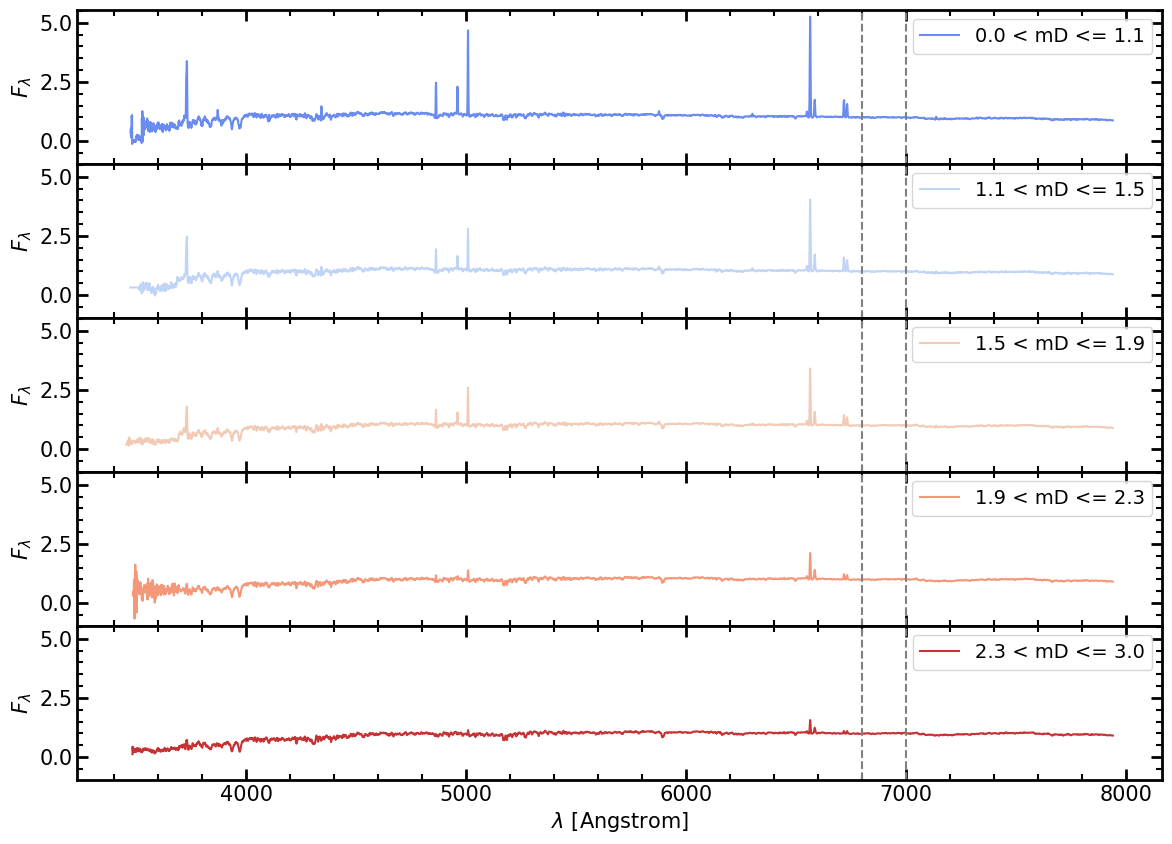

In [23]:
#plot stacked spectra of each bin
fig, axs = plt.subplots(Nbins,1, figsize = (14, 10), sharex = True, sharey = True)
plt.subplots_adjust(wspace = 0., hspace = 0.)

# loop over each bin and plot one stacked spectrum per panel
for i in range(Nbins):
    axs[i].plot(wavelength_stacks[i],flux_stacks[i],color=colors[i],label=labels[i])
    axs[i].legend(fontsize=14,loc='upper right')
    axs[i].set_ylabel('$F_{\lambda}$')

    # Overplot the range where the stacking function normalized by default
    axs[i].axvline(x=6800, ls='--', color='grey')
    axs[i].axvline(x=7000, ls='--', color='grey')

axs[Nbins-1].set_xlabel('$\lambda$ [Angstrom]')
plt.show()

The region between the two vertical lines was used to normalize the spectra in the stacking function. 

## The Stellar Continuum

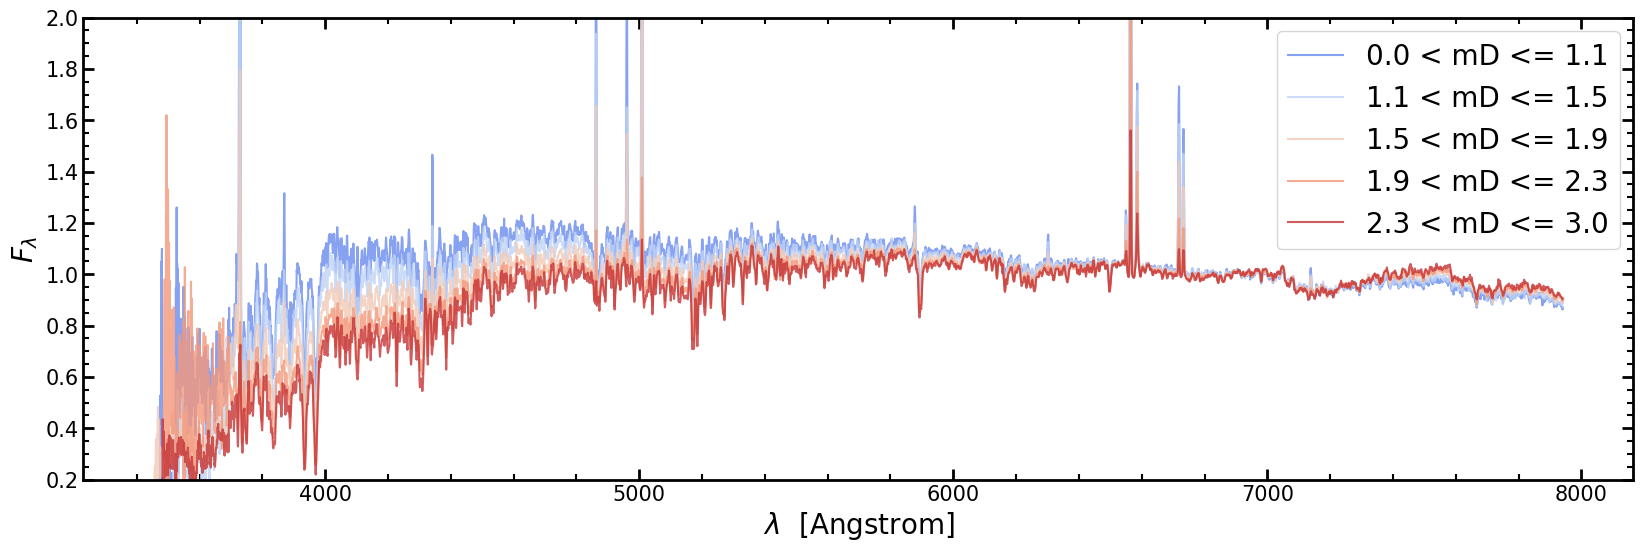

In [24]:
## Plot the spectra on the same panel to compare visually their overall shape
fig, ax = plt.subplots(1,1, figsize = (20, 6), sharex = True, sharey = True)
plt.subplots_adjust(wspace = 0., hspace = 0.)

for i in range(Nbins):
    ax.plot(wavelength_stacks[i], flux_stacks[i], color = colors[i], label = labels[i],alpha=0.8)

ax.set_ylim(0.2,2)

ax.legend(fontsize = 20, loc = 'upper right')
ax.set_xlabel('$\lambda$  [Angstrom]',fontsize=20)
ax.set_ylabel('$F_{\lambda}$',fontsize=20);

As the matter density increases, the continuum emission of the stacked spectra falls lower at shorter wavelengths; galaxies in high-density filaments are redder. This is an indication of an older stellar population. With this normalization, the emission lines (especially those of the lowest-density bin) are cut off to prioritize seeing the continuum. These emission lines will be investigated later.  

## 4000$\mathring A$ Break

The 4000Å Break is a sharp drop in a galaxy's spectrum caused by the accumulation of absorption lines. This spectral feature correlates to past star formation ([Kriek et al. 2011](https://iopscience.iop.org/article/10.1088/0004-637X/743/2/168)), with strong breaks indicating the galaxy is not currently forming a substantial portion of its stellar mass. The Dn4000 index is used to quantify the strength of the 4000Å Break. It is measured by the ratio of the fluxes of the regions outlined by the blue (3850 - 3950 $\mathring A$) and red (4000 - 4100 $\mathring A$) dashed lines in the figure below ([Balogh et al. 1999](https://iopscience.iop.org/article/10.1086/308056)). The 4000$\mathring A$ break can be an indicator of stellar age in a galaxy. 

In [25]:
# normalize spectra in Region 2 of Dn4000
median_flux_4000 = np.zeros(Nbins)

for i in range(Nbins):
    r_wavelength_4000 = (wavelength_stacks[i] < 4100) & (wavelength_stacks[i] > 4000)
    median_flux_4000[i] = np.median(flux_stacks[i][r_wavelength_4000])

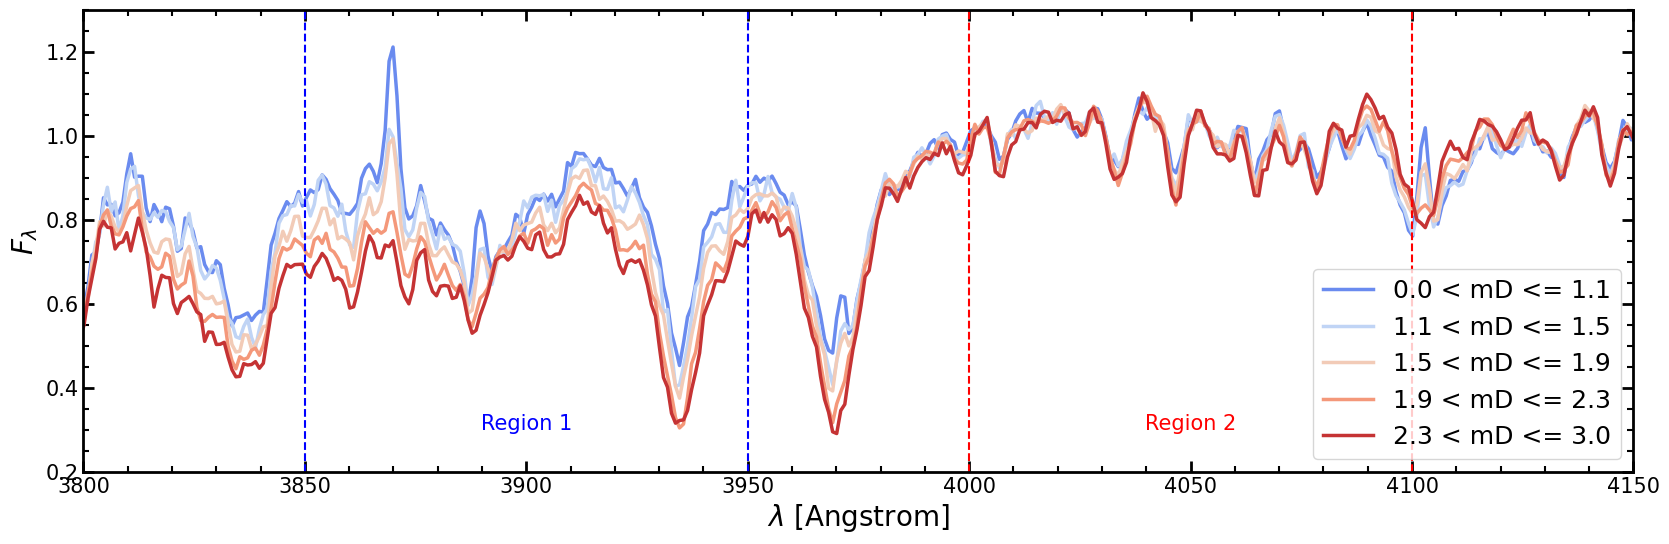

In [26]:
fig, ax = plt.subplots(1,1, figsize=(20, 6), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0., hspace=0.)

# We loop over each bin and overplot the spectra on the same panel
for i in range(Nbins):
    ax.plot(wavelength_stacks[i], flux_stacks[i]/median_flux_4000[i], color=colors[i], label=labels[i], alpha=1, lw=2.5)

ax.set_xlim(3800,4150)
ax.set_ylim(0.2,1.3)

# Region 1 of the Dn4000
ax.axvline(x=3850, color='blue', linestyle='dashed')
ax.axvline(x=3950, color='blue', linestyle='dashed')
ax.text(3900,0.3, 'Region 1', ha='center', color='blue')

# Region 2 of the Dn4000
ax.axvline(x=4000, color='red', linestyle='dashed')
ax.axvline(x=4100, color='red', linestyle='dashed')
ax.text(4050,0.3, 'Region 2', ha='center', color='red')

# Add legend and axis labels
ax.legend(fontsize=18, loc='lower right')
ax.set_xlabel('$\lambda$ [Angstrom]', fontsize=20)
ax.set_ylabel('$F_{\lambda}$', fontsize=20);

This plot focuses on the 4000$\mathring A$ break, normalizing in the red Dn4000 range. We visually note that higher matter density corresponds to a more significant 4000$\mathring A$ break.

Next, we will calculate the Dn4000 index by taking the ratio of the flux density ($f_{\nu}$) in Region 2 and Region1  to quantify this observation. 

### Calculating Dn4000 Index

In [27]:
# Calculate the frequency flux density (f_nu) for each of the matter density bins
c = (3e8)*(1e10) # speed of light in Ansgtrom/second

flux_nu_stacks = []

# for each bin, obtain the flux density (f_nu)
for i in range(Nbins):
    fnu_out = (flux_stacks[i]*1e-17)*((wavelength_stacks[i])**2/c)
    flux_nu_stacks.append(fnu_out)

In [28]:
Dn4000s = []

# for each bin, compute the Dn4000 index
for i in range(Nbins):

    wl = wavelength_stacks[i]
    fnu = flux_nu_stacks[i]
    
    # define red and blue region masks to calculate the Dn4000 index of each of the matter density bins
    region1_mask = (wl < 3950) & (wl > 3850) # Region 1 mask
    region2_mask = (wl < 4100) & (wl > 4000) # Region 2 mask

    # to integrate flux we must know the width of each spectra element
    Nwl = len(wl)
    widths = np.zeros(Nwl)
    # Use the difference between next element and current one up to Nwl-2
    widths[:Nwl-2] = wl[1:Nwl-1] - wl[:Nwl-2]
    # Insert the same value as the second to last bin for the last bin
    widths[Nwl-1] += widths[Nwl-2]

    # integrate flux in Regions 1 and 2 using right-hand Riemann sums
    region1_flux_bin = np.sum(fnu[region1_mask]*widths[region1_mask])
    region2_flux_bin = np.sum(fnu[region2_mask]*widths[region2_mask])    

    # take the flux ratio of Region 1 and 2 for each matter density bin, rounding to 3 decimals
    Dn4000_bin = np.round(region2_flux_bin/region1_flux_bin, 3)
    Dn4000s.append(Dn4000_bin)

In [29]:
# Compute the matter density bin width relative to the median value in each bin 
# (to plot them as lower (lo) and upper (up) error bars below)
xerr_lo = []
xerr_up = []

for i in range(Nbins):
    xwidth_lo = np.round(med_matterdens[i] - bin_levels[i], 4)   #rounded to 4 decimals
    xwidth_up = np.round(bin_levels[i+1] - med_matterdens[i], 4)
    xerr_lo.append(xwidth_lo)
    xerr_up.append(xwidth_up)

# Matter density "error" calculated by finding the lower and upper bin width relative to the 
# median matter density value of each bin
xerr = np.array([xerr_lo, xerr_up])

Text(0.5, 0, 'log(Matter Density)')

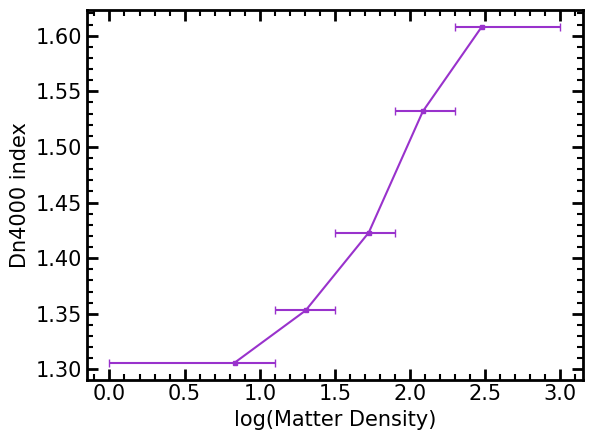

In [30]:
# Plot Dn4000 index as a function of local matter density of each bin
plt.errorbar(med_matterdens,Dn4000s,xerr=xerr,capsize=3,marker='s',markersize=3,color='darkorchid')
plt.ylabel('Dn4000 index')
plt.xlabel('log(Matter Density)')

We take the median value of matter density for each bin. As matter density increases, so does the strength of the 4000Å break, another indicator of older stellar populations for galaxies in high-density regions. These older stellar populations signal quenched galaxies, as young stars die and old red stars dominate. 

## Emission Lines

Emission lines such as Balmer lines (H$\alpha$, H$\beta$, etc.) and forbidden lines (e.g., [OIII]4959,5007) can be used as tracers of star formation and black hole accretion activity in a galaxy. We examine a few typical strong emission lines in bins of increasing environment density.

In [31]:
# normalize spectra in regions near OIII and H-alpha emission lines 
median_flux_OIII = np.zeros(Nbins)

median_flux_Ha = np.zeros(Nbins)

for i in range(Nbins):
    r_wavelength_OIII = (wavelength_stacks[i] < 4950) & (wavelength_stacks[i] > 4880)
    median_flux_OIII[i] = np.median(flux_stacks[i][r_wavelength_OIII])

    r_wavelength_Ha = (wavelength_stacks[i] < 6700) & (wavelength_stacks[i] > 6630)
    median_flux_Ha[i] = np.median(flux_stacks[i][r_wavelength_Ha])

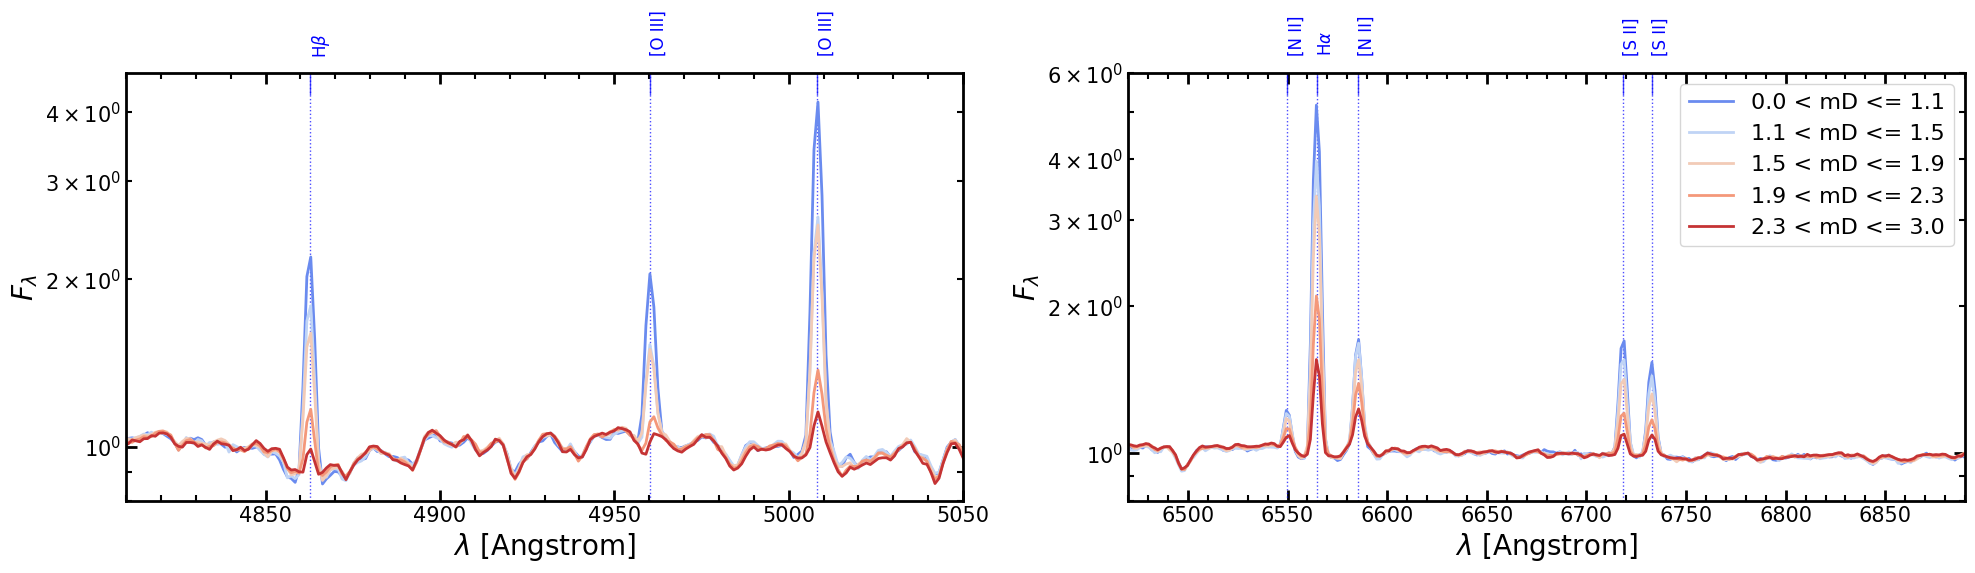

In [32]:
# Initialize the figure with two panels
fig, axs = plt.subplots(1, 2, figsize=(20, 6), sharex='col')
plt.subplots_adjust(wspace = 0.14, hspace=0.0)

# First spectral window to cover Hb, [OIII]4959,5007 in rest-frame
axs[0].set_xlim(4810, 5050)
axs[0].set_ylim(0.8, 4.7)

# Second spectral window to cover Ha, [NII]6548,6584 and [SII]6717,6731 in rest-frame
axs[1].set_xlim(6470, 6890)
axs[1].set_ylim(0.8, 6)

# Overplot vertical lines at location of expected emission lines
add_lines(ax=axs[0], z=0, abs_lines=[])
add_lines(ax=axs[1], z=0, abs_lines=[])

# We loop over the bins and overplot the stacked spectrum from each bin in both spectral windows
for i in range(Nbins):
    axs[0].plot(wavelength_stacks[i], flux_stacks[i]/median_flux_OIII[i], color=colors[i], label=labels[i], alpha=1, lw=2)
    axs[1].plot(wavelength_stacks[i], flux_stacks[i]/median_flux_Ha[i], color=colors[i], label=labels[i], alpha=1, lw=2)

# We use a log scale for the flux density to how the full range of the emission lines
# while also seeing details of the (normalized) continuum shape
axs[0].set_yscale('log')
axs[1].set_yscale('log')

# Label axes
axs[0].set_xlabel('$\lambda$ [Angstrom]', fontsize=20)
axs[0].set_ylabel('$F_{\lambda}$', fontsize=20)
axs[1].set_xlabel('$\lambda$ [Angstrom]', fontsize=20)
axs[1].set_ylabel('$F_{\lambda}$', fontsize=20);

# Add legend to second panel
axs[1].legend(fontsize=16, loc='upper right')

plt.tight_layout()

From the above figure, we can infer the following: 
   * Overall, all emission lines are the strongest in low-density regions (blue spectrum) and their strength decreases with increasing matter density.
   * The H$\alpha$ line is a tracer for star formation. We can see that it is the strongest for galaxies in low-density regions or filaments.
   * The [OIII]$\lambda$5007 line (and associated doublet line at 4959 Angstrom) is luminous either due to low metalicity ionized gas or the presence of AGN but considering this line alone does not allow us to identify the main source of ionization.
   * One could determine the main source of ionization by investigating the emission line ratios and using the BPT diagnostic diagram (as shown in the notebook [01_EmLineGalaxies_SpectraStack.ipynb](https://github.com/astro-datalab/notebooks-latest/blob/master/03_ScienceExamples/EmLineGalaxies/01_EmLineGalaxies_SpectraStack.ipynb))
   * In general, the higher the matter density, the weaker the emission lines are. This could be an indicator of very low star formation and/or AGN activity.

<a class="anchor" id="references"></a>
# References
  
- [Balogh et al. 1999](https://iopscience.iop.org/article/10.1086/308056), ApJ 527, 54
  
- [Elek et al. 2022](https://direct.mit.edu/artl/article/28/1/22/108680/Monte-Carlo-Physarum-Machine-Characteristics-of), Artificial Life 28, 22
  
- [Kriek et al. 2011](https://iopscience.iop.org/article/10.1088/0004-637X/743/2/168), ApJ 743, 168

- [Rines et al. 2005](https://iopscience.iop.org/article/10.1086/433173), AJ 130, 1482

- [Tiwari et al. 2020](https://ui.adsabs.harvard.edu/abs/2020NewA...8101417T/abstract), New Astronomy 81, 101417
  
- [Wilde et al. 2023](https://ui.adsabs.harvard.edu/abs/2023arXiv230102719W/abstract), arXiv:2301.02719